In [62]:
import pandas as pd
import pyarrow.dataset as pads
from SMT_data_starter import readDataSubset

## Helper functions
Functions are created to help calculate number of hits, walks, strikeouts, and batters faced in each game for each pitcher. From those functions, we can further calculate the muscle fatigue and fatigue unit based on the equations provided in an existing MLB fatigue analysis(see paper) Finally, the data identified above are put together in dataframes to summarize the metrics for each pitcher.

In [63]:
PITCH = 1
HIT_IN_PLAY = 4
HOMERUN = 11

def get_game_events(level):
    game_events_subset = readDataSubset('game_events', '2024_SMT_Data_Challenge')
    game_events = game_events_subset.to_table(filter = (pads.field('Season') == 'Season_1884') & (pads.field('HomeTeam') == f'Home{level}')).to_pandas()
    return game_events

def get_hits(game_info, game_events):
    at_bat_list = game_info['at_bat'].unique().tolist()
    hits = 0
    for at_bat in at_bat_list:
        at_bat_events = game_events[game_events['at_bat'] == at_bat]['event_code'].tolist()
        if HOMERUN in at_bat_events:
            hits += 1
        if HIT_IN_PLAY in at_bat_events:
            next_at_bat = at_bat + 1
            current_batter = game_info[game_info['at_bat'] == at_bat]['batter'].values[0]
            if current_batter in game_info[game_info['at_bat'] == next_at_bat][['first_baserunner', 'second_baserunner', 'third_baserunner']].values:
                hits += 1
    return hits

def get_walks(game_info, game_events):
    at_bat_list = game_info['at_bat'].unique().tolist()
    walks = 0
    for at_bat in at_bat_list:
        at_bat_events = game_events[game_events['at_bat'] == at_bat]['event_code'].tolist()
        if HIT_IN_PLAY not in at_bat_events:
            next_at_bat = at_bat + 1
            current_batter = game_info[game_info['at_bat'] == at_bat]['batter'].values[0]
            if current_batter in game_info[game_info['at_bat'] == next_at_bat][['first_baserunner', 'second_baserunner', 'third_baserunner']].values:
                walks += 1
    return walks

def get_strikeouts(game_info, game_events):
    at_bat_list = game_info['at_bat'].unique().tolist()
    strikeouts = 0
    for at_bat in at_bat_list:
        at_bat_events = game_events[game_events['at_bat'] == at_bat]['event_code'].tolist()
        if HOMERUN not in at_bat_events and HIT_IN_PLAY not in at_bat_events:
            next_at_bat = at_bat + 1
            current_batter = game_info[game_info['at_bat'] == at_bat]['batter'].values[0]
            if current_batter not in game_info[game_info['at_bat'] == next_at_bat][['first_baserunner', 'second_baserunner', 'third_baserunner']].values:
                strikeouts += 1
    return strikeouts

def get_batters_faced(game_info):
    return game_info['batter'].nunique()

def get_pitching_metrics(game_info, level):
    hits_list = []
    walks_list = []
    strikeout_list = []
    batters_faced_list = []
    innings_pitched_list = []
    is_starter_list = []
    game_str_list = game_info['game_str'].unique().tolist()
    for game_str in game_str_list:
        pitchers_list = game_info[game_info['game_str'] == game_str]['pitcher'].unique().tolist()
        for pitcher in pitchers_list:
            game_info_subset = game_info[(game_info['pitcher'] == pitcher) & (game_info['game_str'] == game_str)]
            inning_list = game_info_subset['inning'].unique().tolist()
            game_events = get_game_events(level)[get_game_events(level)['game_str'] == game_str]
            hits = get_hits(game_info_subset, game_events)
            walks = get_walks(game_info_subset, game_events)
            strikeouts = get_strikeouts(game_info_subset, game_events)
            batters_faced = get_batters_faced(game_info_subset)
            hits_list.append(hits)
            walks_list.append(walks)
            strikeout_list.append(strikeouts)
            batters_faced_list.append(batters_faced)
            innings_pitched_list.append(game_info_subset['inning'].nunique())
            if inning_list[0] == 1:
                is_starter_list.append(1)
            else:
                is_starter_list.append(0)
    return hits_list, walks_list, strikeout_list, batters_faced_list, innings_pitched_list, is_starter_list

def apply_fatigue_unit_equation(cumulative_pitching_metrics):
    whip = cumulative_pitching_metrics['WHIP']
    bb_ip = cumulative_pitching_metrics['BB/IP']
    k_ip = cumulative_pitching_metrics['K/IP']
    batters_ip = cumulative_pitching_metrics['Batters/IP']
    ip = cumulative_pitching_metrics['innings_pitched']
    starting = cumulative_pitching_metrics['games_started']
    relieving = cumulative_pitching_metrics['games_relieved']
    fatigue_units_list = (0.18*whip + 0.14*bb_ip + 0.34*k_ip - 0.16*batters_ip + 0.08*ip + 0.3*starting + 0.14*relieving).tolist()
    return fatigue_units_list

def apply_muscle_fatigue_equation(pitching_metrics):
    total_pitches = pitching_metrics['total_pitches']
    pace = pitching_metrics['pace']
    muscle_fatigue_list = (0.10963 + 0.032 * total_pitches - 0.0023 * pace).tolist()
    return muscle_fatigue_list

def calculate_pace(game_info, level):
    pace_list = []
    total_pitches_list = []
    game_str_list = game_info['game_str'].unique().tolist()
    for game_str in game_str_list:
        pitchers_list = game_info[game_info['game_str'] == game_str]['pitcher'].unique().tolist()
        for pitcher in pitchers_list:
            time = 0
            num_pitches = 0
            game_info_subset = game_info[(game_info['pitcher'] == pitcher) & (game_info['game_str'] == game_str)]
            game_events_subset = get_game_events(level)[get_game_events(level)['game_str'] == game_str]
            if game_str == '1884_143_Vis4BE_Home4A':
                game_events_subset['timestamp'] = game_events_subset['timestamp'] + 500  # Timestamps are systematically off by 500ms for this game
            at_bats = game_info_subset['at_bat'].unique().tolist()
            for at_bat in at_bats:
                pitches_df = game_events_subset[(game_events_subset['at_bat'] == at_bat) & (game_events_subset['event_code'] == PITCH)]
                total_pitches = pitches_df['event_code'].count()
                num_pitches += total_pitches
                if total_pitches > 0:
                    first_pitch = pitches_df.iloc[0]['timestamp']
                    last_pitch = pitches_df.iloc[-1]['timestamp']
                    time += ((last_pitch - first_pitch) / total_pitches) / 1000
            average_pace = time / len(at_bats)
            pace_list.append(average_pace)
            total_pitches_list.append(num_pitches)
    return total_pitches_list, pace_list

def calculate_rest_days(cumulative_metrics):
    game_str = cumulative_metrics['game_str'].tolist()
    game_day = []
    rest_days = []
    pitchers_list = cumulative_metrics['pitcher'].unique().tolist()
    for games in game_str:
        day = int(games[5:8])
        game_day.append(day)
    cumulative_metrics['game_day'] = game_day
    for pitcher in pitchers_list:
        df = cumulative_metrics[cumulative_metrics['pitcher'] == pitcher]
        days = df['game_day'].tolist()
        for i in range(len(days)):
            if i == 0:
                rest_days.append(0)
            else:
                rest_days.append(days[i] - days[i-1] - 1)
    return rest_days

def create_pitching_metrics_df(game_info, hits_list, walks_list, strikeout_list, batters_faced_list, innings_pitched_list, is_starter_list):
    pitching_metrics = game_info[['pitcher', 'game_str']].drop_duplicates().reset_index(drop = True)
    pitching_metrics['hits'] = hits_list
    pitching_metrics['walks'] = walks_list
    pitching_metrics['strikeouts'] = strikeout_list
    pitching_metrics['batters_faced'] = batters_faced_list
    pitching_metrics['innings_pitched'] = innings_pitched_list
    pitching_metrics['is_starter'] = is_starter_list
    pitching_metrics['is_reliever'] = pitching_metrics['is_starter'].apply(lambda x: 1 if x == 0 else 0)
    pitching_metrics['BB/IP'] = pitching_metrics['walks'] / pitching_metrics['innings_pitched']
    pitching_metrics['K/IP'] = pitching_metrics['strikeouts'] / pitching_metrics['innings_pitched']
    pitching_metrics['Batters/IP'] = pitching_metrics['batters_faced'] / pitching_metrics['innings_pitched']
    pitching_metrics['WHIP'] = (pitching_metrics['hits'] + pitching_metrics['walks']) / pitching_metrics['innings_pitched']
    return pitching_metrics

def create_cumulative_pitching_metrics_df(pitching_metrics):
    info = pitching_metrics[['pitcher', 'game_str']]
    cumulative_pitching_metrics = pitching_metrics.groupby('pitcher')[['hits', 'walks', 'strikeouts', 'batters_faced', 'innings_pitched', 'is_starter', 'is_reliever', 'total_pitches', 'pace']].cumsum()
    cumulative_pitching_metrics = pd.concat([info, cumulative_pitching_metrics], axis=1)
    cumulative_pitching_metrics['games_played'] = pitching_metrics.groupby('pitcher')['game_str'].cumcount() + 1
    cumulative_pitching_metrics['BB/IP'] = cumulative_pitching_metrics['walks'] / cumulative_pitching_metrics['innings_pitched']
    cumulative_pitching_metrics['K/IP'] = cumulative_pitching_metrics['strikeouts'] / cumulative_pitching_metrics['innings_pitched']
    cumulative_pitching_metrics['Batters/IP'] = cumulative_pitching_metrics['batters_faced'] / cumulative_pitching_metrics['innings_pitched']
    cumulative_pitching_metrics['WHIP'] = (cumulative_pitching_metrics['walks'] + cumulative_pitching_metrics['hits']) / cumulative_pitching_metrics['innings_pitched']
    cumulative_pitching_metrics['average_pace'] = cumulative_pitching_metrics['pace'] / cumulative_pitching_metrics['games_played']
    cumulative_pitching_metrics.rename(columns={'is_starter': 'games_started', 'is_reliever': 'games_relieved'}, inplace=True)
    return cumulative_pitching_metrics

def get_season_metrics_df(cumulative_pitching_metrics):
    df = pd.DataFrame()
    level = int(cumulative_pitching_metrics['game_str'][0][-2])
    pitchers_list = cumulative_pitching_metrics['pitcher'].unique().tolist()
    for pitcher in pitchers_list:
        rest_day_sum = cumulative_pitching_metrics[cumulative_pitching_metrics['pitcher'] == pitcher]['rest_days'].sum()
        pitcher_last_row = cumulative_pitching_metrics[cumulative_pitching_metrics['pitcher'] == pitcher].iloc[-1]
        pitcher_last_row['average_rest_days'] = rest_day_sum / pitcher_last_row['games_played']
        df = pd.concat([df, pitcher_last_row.to_frame().transpose()], axis=0, ignore_index=True)
    df.drop(columns=['game_str'], inplace=True)
    df['level'] = level
    return df

## Getting season metrics for all pitchers

In [64]:
game_info_subset = readDataSubset('game_info', '2024_SMT_Data_Challenge')
game_info_1A = game_info_subset.to_table(filter = (pads.field('Season') == 'Season_1884') & (pads.field('home_team') == 'Home1A') & (pads.field('top_bottom') == 'top') & (pads.field('pitcher') < 1000) & (pads.field('inning') < 10)).to_pandas().dropna(subset=['pitcher'])
game_info_2A = game_info_subset.to_table(filter = (pads.field('Season') == 'Season_1884') & (pads.field('home_team') == 'Home2A') & (pads.field('top_bottom') == 'top') & (pads.field('pitcher') < 1000) & (pads.field('inning') < 10)).to_pandas().dropna(subset=['pitcher'])
game_info_3A = game_info_subset.to_table(filter = (pads.field('Season') == 'Season_1884') & (pads.field('home_team') == 'Home3A') & (pads.field('top_bottom') == 'top') & (pads.field('pitcher') < 1000) & (pads.field('inning') < 10)).to_pandas().dropna(subset=['pitcher'])
game_info_4A = game_info_subset.to_table(filter = (pads.field('Season') == 'Season_1884') & (pads.field('home_team') == 'Home4A') & (pads.field('top_bottom') == 'top') & (pads.field('pitcher') < 1000) & (pads.field('inning') < 10)).to_pandas().dropna(subset=['pitcher'])

In [65]:
game_events_subset = readDataSubset('game_events', '2024_SMT_Data_Challenge')
game_events_1A = game_events_subset.to_table(filter = (pads.field('Season') == 'Season_1884') & (pads.field('HomeTeam') == 'Home1A')).to_pandas()
game_events_2A = game_events_subset.to_table(filter = (pads.field('Season') == 'Season_1884') & (pads.field('HomeTeam') == 'Home2A')).to_pandas()
game_events_3A = game_events_subset.to_table(filter = (pads.field('Season') == 'Season_1884') & (pads.field('HomeTeam') == 'Home3A')).to_pandas()
game_events_4A = game_events_subset.to_table(filter = (pads.field('Season') == 'Season_1884') & (pads.field('HomeTeam') == 'Home4A')).to_pandas()

In [66]:
pitchers_list_1A = game_info_1A['pitcher'].unique().tolist()
pitchers_list_2A = game_info_2A['pitcher'].unique().tolist()
pitchers_list_3A = game_info_3A['pitcher'].unique().tolist()
pitchers_list_4A = game_info_4A['pitcher'].unique().tolist()

In [67]:
hits_list_1A, walks_list_1A, strikeout_list_1A, batters_faced_list_1A, innings_pitched_list_1A, is_starter_list_1A = get_pitching_metrics(game_info_1A, '1A')
hits_list_2A, walks_list_2A, strikeout_list_2A, batters_faced_list_2A, innings_pitched_list_2A, is_starter_list_2A = get_pitching_metrics(game_info_2A, '2A')
hits_list_3A, walks_list_3A, strikeout_list_3A, batters_faced_list_3A, innings_pitched_list_3A, is_starter_list_3A = get_pitching_metrics(game_info_3A, '3A')
hits_list_4A, walks_list_4A, strikeout_list_4A, batters_faced_list_4A, innings_pitched_list_4A, is_starter_list_4A = get_pitching_metrics(game_info_4A, '4A')

In [68]:
pitching_metrics_1A = create_pitching_metrics_df(game_info_1A, hits_list_1A, walks_list_1A, strikeout_list_1A, batters_faced_list_1A, innings_pitched_list_1A, is_starter_list_1A)
pitching_metrics_2A = create_pitching_metrics_df(game_info_2A, hits_list_2A, walks_list_2A, strikeout_list_2A, batters_faced_list_2A, innings_pitched_list_2A, is_starter_list_2A)
pitching_metrics_3A = create_pitching_metrics_df(game_info_3A, hits_list_3A, walks_list_3A, strikeout_list_3A, batters_faced_list_3A, innings_pitched_list_3A, is_starter_list_3A)
pitching_metrics_4A = create_pitching_metrics_df(game_info_4A, hits_list_4A, walks_list_4A, strikeout_list_4A, batters_faced_list_4A, innings_pitched_list_4A, is_starter_list_4A)

In [69]:
total_pitches_list_1A, pace_list_1A = calculate_pace(game_info_1A, '1A')
total_pitches_list_2A, pace_list_2A = calculate_pace(game_info_2A, '2A')
total_pitches_list_3A, pace_list_3A = calculate_pace(game_info_3A, '3A')
total_pitches_list_4A, pace_list_4A = calculate_pace(game_info_4A, '4A')

In [70]:
pitching_metrics_1A['total_pitches'] = total_pitches_list_1A
pitching_metrics_1A['pace'] = pace_list_1A
pitching_metrics_2A['total_pitches'] = total_pitches_list_2A
pitching_metrics_2A['pace'] = pace_list_2A
pitching_metrics_3A['total_pitches'] = total_pitches_list_3A
pitching_metrics_3A['pace'] = pace_list_3A
pitching_metrics_4A['total_pitches'] = total_pitches_list_4A
pitching_metrics_4A['pace'] = pace_list_4A

In [71]:
pitching_metrics_1A['muscle_fatigue'] = apply_muscle_fatigue_equation(pitching_metrics_1A)
pitching_metrics_2A['muscle_fatigue'] = apply_muscle_fatigue_equation(pitching_metrics_2A)
pitching_metrics_3A['muscle_fatigue'] = apply_muscle_fatigue_equation(pitching_metrics_3A)
pitching_metrics_4A['muscle_fatigue'] = apply_muscle_fatigue_equation(pitching_metrics_4A)

In [72]:
cumulative_metrics_1A = create_cumulative_pitching_metrics_df(pitching_metrics_1A).drop(columns=['pace'])
cumulative_metrics_2A = create_cumulative_pitching_metrics_df(pitching_metrics_2A).drop(columns=['pace'])
cumulative_metrics_3A = create_cumulative_pitching_metrics_df(pitching_metrics_3A).drop(columns=['pace'])
cumulative_metrics_4A = create_cumulative_pitching_metrics_df(pitching_metrics_4A).drop(columns=['pace'])

In [73]:
cumulative_metrics_1A['fatigue_units'] = apply_fatigue_unit_equation(cumulative_metrics_1A)
cumulative_metrics_2A['fatigue_units'] = apply_fatigue_unit_equation(cumulative_metrics_2A)
cumulative_metrics_3A['fatigue_units'] = apply_fatigue_unit_equation(cumulative_metrics_3A)
cumulative_metrics_4A['fatigue_units'] = apply_fatigue_unit_equation(cumulative_metrics_4A)

muscle_fatigue_1A_cumsum = pitching_metrics_1A.groupby('pitcher').agg({'muscle_fatigue': 'cumsum'})['muscle_fatigue'].tolist()
muscle_fatigue_2A_cumsum = pitching_metrics_2A.groupby('pitcher').agg({'muscle_fatigue': 'cumsum'})['muscle_fatigue'].tolist()
muscle_fatigue_3A_cumsum = pitching_metrics_3A.groupby('pitcher').agg({'muscle_fatigue': 'cumsum'})['muscle_fatigue'].tolist()
muscle_fatigue_4A_cumsum = pitching_metrics_4A.groupby('pitcher').agg({'muscle_fatigue': 'cumsum'})['muscle_fatigue'].tolist()

cumulative_metrics_1A['average_muscle_fatigue'] = muscle_fatigue_1A_cumsum / (cumulative_metrics_1A['games_played'])
cumulative_metrics_2A['average_muscle_fatigue'] = muscle_fatigue_2A_cumsum / (cumulative_metrics_2A['games_played'])
cumulative_metrics_3A['average_muscle_fatigue'] = muscle_fatigue_3A_cumsum / (cumulative_metrics_3A['games_played'])
cumulative_metrics_4A['average_muscle_fatigue'] = muscle_fatigue_4A_cumsum / (cumulative_metrics_4A['games_played'])

In [74]:
cumulative_metrics_1A = cumulative_metrics_1A.groupby('pitcher').apply(pd.DataFrame).reset_index(drop=True)
cumulative_metrics_2A = cumulative_metrics_2A.groupby('pitcher').apply(pd.DataFrame).reset_index(drop=True)
cumulative_metrics_3A = cumulative_metrics_3A.groupby('pitcher').apply(pd.DataFrame).reset_index(drop=True)
cumulative_metrics_4A = cumulative_metrics_4A.groupby('pitcher').apply(pd.DataFrame).reset_index(drop=True)

In [75]:
cumulative_metrics_1A['rest_days'] = calculate_rest_days(cumulative_metrics_1A)
cumulative_metrics_2A['rest_days'] = calculate_rest_days(cumulative_metrics_2A)
cumulative_metrics_3A['rest_days'] = calculate_rest_days(cumulative_metrics_3A)
cumulative_metrics_4A['rest_days'] = calculate_rest_days(cumulative_metrics_4A)

In [76]:
season_df = pd.concat([get_season_metrics_df(cumulative_metrics_1A), get_season_metrics_df(cumulative_metrics_2A), get_season_metrics_df(cumulative_metrics_3A), get_season_metrics_df(cumulative_metrics_4A)]).drop(columns=['rest_days'])
season_df.rename(columns={'game_day': 'last_game_day_played'}, inplace=True)
season_df.reset_index(drop=True)

,pitcher,hits,walks,strikeouts,batters_faced,innings_pitched,games_started,games_relieved,total_pitches,games_played,BB/IP,K/IP,Batters/IP,WHIP,average_pace,fatigue_units,average_muscle_fatigue,last_game_day_played,average_rest_days,level
0,305,14,0,4,35,14,1,3,189,4,0.0,0.285714,2.5,1.0,13.096954,1.717143,1.591507,96,6.75,1
1,344,13,2,4,30,11,0,4,165,4,0.181818,0.363636,2.727273,1.363636,10.501347,1.398182,1.405477,54,5.25,1
2,354,46,10,8,72,39,8,0,575,8,0.25641,0.205128,1.846154,1.435897,12.482032,5.588718,2.380921,135,9.75,1
3,364,37,5,11,54,27,6,0,433,6,0.185185,0.407407,2.0,1.555556,13.661606,4.084444,2.387542,136,18.833333,1
4,367,12,4,8,62,17,0,9,240,9,0.235294,0.470588,3.647059,0.941176,12.48099,2.398824,0.934257,76,6.666667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,956,21,3,13,96,32,1,15,395,16,0.09375,0.40625,3.0,0.75,12.873518,4.76625,0.870021,106,5.625,4
116,964,13,2,6,52,16,0,10,197,10,0.125,0.375,3.25,0.9375,14.667017,2.47375,0.706296,54,4.1,4
117,978,9,4,4,52,17,0,10,216,10,0.235294,0.235294,3.058824,0.764706,16.263733,2.521176,0.763423,143,5.6,4
118,987,22,1,4,66,19,1,9,274,10,0.052632,0.210526,3.473684,1.210526,14.329481,2.821053,0.953472,120,7.3,4


In [77]:
season_df[['average_rest_days', 'fatigue_units', 'average_muscle_fatigue', 'WHIP', 'K/IP', 'innings_pitched', 'total_pitches', 'games_played']] = season_df[['average_rest_days', 'fatigue_units', 'average_muscle_fatigue', 'WHIP', 'K/IP', 'innings_pitched', 'total_pitches', 'games_played']].astype(float)

## Getting metrics for pitchers who played in extra innings

In [78]:
game_info_1A_extra = game_info_subset.to_table(filter = (pads.field('Season') == 'Season_1884') & (pads.field('home_team') == 'Home1A') & (pads.field('top_bottom') == 'top') & (pads.field('pitcher') < 1000) & (pads.field('inning') > 9)).to_pandas().dropna(subset=['pitcher'])
game_info_2A_extra = game_info_subset.to_table(filter = (pads.field('Season') == 'Season_1884') & (pads.field('home_team') == 'Home2A') & (pads.field('top_bottom') == 'top') & (pads.field('pitcher') < 1000) & (pads.field('inning') > 9)).to_pandas().dropna(subset=['pitcher'])
game_info_3A_extra = game_info_subset.to_table(filter = (pads.field('Season') == 'Season_1884') & (pads.field('home_team') == 'Home3A') & (pads.field('top_bottom') == 'top') & (pads.field('pitcher') < 1000) & (pads.field('inning') > 9)).to_pandas().dropna(subset=['pitcher'])
game_info_4A_extra = game_info_subset.to_table(filter = (pads.field('Season') == 'Season_1884') & (pads.field('home_team') == 'Home4A') & (pads.field('top_bottom') == 'top') & (pads.field('pitcher') < 1000) & (pads.field('inning') > 9)).to_pandas().dropna(subset=['pitcher'])

In [79]:
hits_list_1A_extra, walks_list_1A_extra, strikeout_list_1A_extra, batters_faced_list_1A_extra, innings_pitched_list_1A_extra, is_starter_list_1A_extra = get_pitching_metrics(game_info_1A_extra, '1A')
hits_list_2A_extra, walks_list_2A_extra, strikeout_list_2A_extra, batters_faced_list_2A_extra, innings_pitched_list_2A_extra, is_starter_list_2A_extra = get_pitching_metrics(game_info_2A_extra, '2A')
hits_list_3A_extra, walks_list_3A_extra, strikeout_list_3A_extra, batters_faced_list_3A_extra, innings_pitched_list_3A_extra, is_starter_list_3A_extra = get_pitching_metrics(game_info_3A_extra, '3A')
hits_list_4A_extra, walks_list_4A_extra, strikeout_list_4A_extra, batters_faced_list_4A_extra, innings_pitched_list_4A_extra, is_starter_list_4A_extra = get_pitching_metrics(game_info_4A_extra, '4A')

In [80]:
pitching_metrics_1A_extra = create_pitching_metrics_df(game_info_1A_extra, hits_list_1A_extra, walks_list_1A_extra, strikeout_list_1A_extra, batters_faced_list_1A_extra, innings_pitched_list_1A_extra, is_starter_list_1A_extra)
pitching_metrics_2A_extra = create_pitching_metrics_df(game_info_2A_extra, hits_list_2A_extra, walks_list_2A_extra, strikeout_list_2A_extra, batters_faced_list_2A_extra, innings_pitched_list_2A_extra, is_starter_list_2A_extra)
pitching_metrics_3A_extra = create_pitching_metrics_df(game_info_3A_extra, hits_list_3A_extra, walks_list_3A_extra, strikeout_list_3A_extra, batters_faced_list_3A_extra, innings_pitched_list_3A_extra, is_starter_list_3A_extra)
pitching_metrics_4A_extra = create_pitching_metrics_df(game_info_4A_extra, hits_list_4A_extra, walks_list_4A_extra, strikeout_list_4A_extra, batters_faced_list_4A_extra, innings_pitched_list_4A_extra, is_starter_list_4A_extra)

In [81]:
total_pitches_list_1A_extra, pace_list_1A_extra = calculate_pace(game_info_1A_extra, '1A')
total_pitches_list_2A_extra, pace_list_2A_extra = calculate_pace(game_info_2A_extra, '2A')
total_pitches_list_3A_extra, pace_list_3A_extra = calculate_pace(game_info_3A_extra, '3A')
total_pitches_list_4A_extra, pace_list_4A_extra = calculate_pace(game_info_4A_extra, '4A')

In [82]:
pitching_metrics_1A_extra['total_pitches'] = total_pitches_list_1A_extra
pitching_metrics_1A_extra['pace'] = pace_list_1A_extra
pitching_metrics_2A_extra['total_pitches'] = total_pitches_list_2A_extra
pitching_metrics_2A_extra['pace'] = pace_list_2A_extra
pitching_metrics_3A_extra['total_pitches'] = total_pitches_list_3A_extra
pitching_metrics_3A_extra['pace'] = pace_list_3A_extra
pitching_metrics_4A_extra['total_pitches'] = total_pitches_list_4A_extra
pitching_metrics_4A_extra['pace'] = pace_list_4A_extra

In [83]:
pitching_metrics_1A_extra['muscle_fatigue'] = apply_muscle_fatigue_equation(pitching_metrics_1A_extra)
pitching_metrics_2A_extra['muscle_fatigue'] = apply_muscle_fatigue_equation(pitching_metrics_2A_extra)
pitching_metrics_3A_extra['muscle_fatigue'] = apply_muscle_fatigue_equation(pitching_metrics_3A_extra)
pitching_metrics_4A_extra['muscle_fatigue'] = apply_muscle_fatigue_equation(pitching_metrics_4A_extra)

In [84]:
cumulative_metrics_1A_extra = create_cumulative_pitching_metrics_df(pitching_metrics_1A_extra).drop(columns=['pace'])
cumulative_metrics_2A_extra = create_cumulative_pitching_metrics_df(pitching_metrics_2A_extra).drop(columns=['pace'])
cumulative_metrics_3A_extra = create_cumulative_pitching_metrics_df(pitching_metrics_3A_extra).drop(columns=['pace'])
cumulative_metrics_4A_extra = create_cumulative_pitching_metrics_df(pitching_metrics_4A_extra).drop(columns=['pace'])

In [85]:
cumulative_metrics_1A_extra['fatigue_units'] = apply_fatigue_unit_equation(cumulative_metrics_1A_extra)
cumulative_metrics_2A_extra['fatigue_units'] = apply_fatigue_unit_equation(cumulative_metrics_2A_extra)
cumulative_metrics_3A_extra['fatigue_units'] = apply_fatigue_unit_equation(cumulative_metrics_3A_extra)
cumulative_metrics_4A_extra['fatigue_units'] = apply_fatigue_unit_equation(cumulative_metrics_4A_extra)

muscle_fatigue_1A_extra_cumsum = pitching_metrics_1A_extra.groupby('pitcher').agg({'muscle_fatigue': 'cumsum'})['muscle_fatigue'].tolist()
muscle_fatigue_2A_extra_cumsum = pitching_metrics_2A_extra.groupby('pitcher').agg({'muscle_fatigue': 'cumsum'})['muscle_fatigue'].tolist()
muscle_fatigue_3A_extra_cumsum = pitching_metrics_3A_extra.groupby('pitcher').agg({'muscle_fatigue': 'cumsum'})['muscle_fatigue'].tolist()
muscle_fatigue_4A_extra_cumsum = pitching_metrics_4A_extra.groupby('pitcher').agg({'muscle_fatigue': 'cumsum'})['muscle_fatigue'].tolist()

cumulative_metrics_1A_extra['average_muscle_fatigue'] = muscle_fatigue_1A_extra_cumsum / (cumulative_metrics_1A_extra['games_played'])
cumulative_metrics_2A_extra['average_muscle_fatigue'] = muscle_fatigue_2A_extra_cumsum / (cumulative_metrics_2A_extra['games_played'])
cumulative_metrics_3A_extra['average_muscle_fatigue'] = muscle_fatigue_3A_extra_cumsum / (cumulative_metrics_3A_extra['games_played'])
cumulative_metrics_4A_extra['average_muscle_fatigue'] = muscle_fatigue_4A_extra_cumsum / (cumulative_metrics_4A_extra['games_played'])

In [86]:
cumulative_metrics_1A_extra = cumulative_metrics_1A_extra.groupby('pitcher').apply(pd.DataFrame).reset_index(drop=True)
cumulative_metrics_2A_extra = cumulative_metrics_2A_extra.groupby('pitcher').apply(pd.DataFrame).reset_index(drop=True)
cumulative_metrics_3A_extra = cumulative_metrics_3A_extra.groupby('pitcher').apply(pd.DataFrame).reset_index(drop=True)
cumulative_metrics_4A_extra = cumulative_metrics_4A_extra.groupby('pitcher').apply(pd.DataFrame).reset_index(drop=True)

In [87]:
cumulative_metrics_1A_extra['rest_days'] = calculate_rest_days(cumulative_metrics_1A_extra)
cumulative_metrics_2A_extra['rest_days'] = calculate_rest_days(cumulative_metrics_2A_extra)
cumulative_metrics_3A_extra['rest_days'] = calculate_rest_days(cumulative_metrics_3A_extra)
cumulative_metrics_4A_extra['rest_days'] = calculate_rest_days(cumulative_metrics_4A_extra)

In [88]:
season_df_extra = pd.concat([get_season_metrics_df(cumulative_metrics_1A_extra), get_season_metrics_df(cumulative_metrics_2A_extra), get_season_metrics_df(cumulative_metrics_3A_extra), get_season_metrics_df(cumulative_metrics_4A_extra)]).drop(columns=['rest_days'])
season_df_extra.rename(columns={'game_day': 'last_game_day_played'}, inplace=True)
season_df_extra.reset_index(drop=True)

,pitcher,hits,walks,strikeouts,batters_faced,innings_pitched,games_started,games_relieved,total_pitches,games_played,BB/IP,K/IP,Batters/IP,WHIP,average_pace,fatigue_units,average_muscle_fatigue,last_game_day_played,average_rest_days,level
0,411,2,0,0,5,1,0,1,12,1,0.0,0.0,5.0,2.0,8.10248,-0.22,0.474994,131,0.0,1
1,521,0,0,1,4,1,0,1,15,1,0.0,1.0,4.0,0.0,15.344767,-0.08,0.554337,113,0.0,1
2,552,2,0,0,5,1,0,1,17,1,0.0,0.0,5.0,2.0,13.08395,-0.22,0.623537,32,0.0,1
3,343,1,0,1,5,2,0,1,23,1,0.0,0.5,2.5,0.5,18.9625,0.16,0.802016,71,0.0,2
4,344,3,1,0,11,3,0,2,41,2,0.333333,0.0,3.666667,1.333333,25.438089,0.22,0.707122,110,19.0,2
5,367,2,1,0,5,1,0,1,8,1,1.0,0.0,5.0,3.0,3.115,0.1,0.358465,110,0.0,2
6,886,4,1,1,8,2,0,1,45,1,0.5,0.5,4.0,2.5,14.8324,0.35,1.515515,123,0.0,2
7,943,1,0,0,6,2,0,2,22,2,0.0,0.0,3.0,0.5,16.370694,0.05,0.423977,122,2.0,2
8,436,1,0,0,4,1,0,1,14,1,0.0,0.0,4.0,1.0,13.077083,-0.24,0.527553,78,0.0,3
9,585,0,1,0,7,2,0,2,31,2,0.5,0.0,3.5,0.5,17.732604,0.04,0.564845,109,11.0,3


In [89]:
season_df.reset_index(drop=True)
season_df_extra.reset_index(drop=True)

,pitcher,hits,walks,strikeouts,batters_faced,innings_pitched,games_started,games_relieved,total_pitches,games_played,BB/IP,K/IP,Batters/IP,WHIP,average_pace,fatigue_units,average_muscle_fatigue,last_game_day_played,average_rest_days,level
0,411,2,0,0,5,1,0,1,12,1,0.0,0.0,5.0,2.0,8.10248,-0.22,0.474994,131,0.0,1
1,521,0,0,1,4,1,0,1,15,1,0.0,1.0,4.0,0.0,15.344767,-0.08,0.554337,113,0.0,1
2,552,2,0,0,5,1,0,1,17,1,0.0,0.0,5.0,2.0,13.08395,-0.22,0.623537,32,0.0,1
3,343,1,0,1,5,2,0,1,23,1,0.0,0.5,2.5,0.5,18.9625,0.16,0.802016,71,0.0,2
4,344,3,1,0,11,3,0,2,41,2,0.333333,0.0,3.666667,1.333333,25.438089,0.22,0.707122,110,19.0,2
5,367,2,1,0,5,1,0,1,8,1,1.0,0.0,5.0,3.0,3.115,0.1,0.358465,110,0.0,2
6,886,4,1,1,8,2,0,1,45,1,0.5,0.5,4.0,2.5,14.8324,0.35,1.515515,123,0.0,2
7,943,1,0,0,6,2,0,2,22,2,0.0,0.0,3.0,0.5,16.370694,0.05,0.423977,122,2.0,2
8,436,1,0,0,4,1,0,1,14,1,0.0,0.0,4.0,1.0,13.077083,-0.24,0.527553,78,0.0,3
9,585,0,1,0,7,2,0,2,31,2,0.5,0.0,3.5,0.5,17.732604,0.04,0.564845,109,11.0,3


## Regression Analysis
We have chosen ridge regression, random forest, and XGBoost as the regression models. We use ridge regression instead of simple linear regression as we believe there could be collinearity between some of the features. Random forest and XGBoost are used to help identify if there is a non-linear relationship between the features and the target.

In [90]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [91]:
extra_inning_pitchers_list = season_df_extra['pitcher'].tolist()
extra_inning_pitchers_level_list = season_df_extra['level'].tolist()
regular_inning_df = pd.DataFrame()
dataframes = []
for i in range(len(extra_inning_pitchers_list)):
    filtered_df = season_df[(season_df['pitcher'] == extra_inning_pitchers_list[i]) & (season_df['level'] == extra_inning_pitchers_level_list[i])]
    dataframes.append(filtered_df)
regular_inning_df = pd.concat(dataframes, ignore_index=True)

In [92]:
X = regular_inning_df[['average_rest_days', 'fatigue_units', 'average_muscle_fatigue', 'games_played', 'total_pitches', 'level']]
y = season_df_extra['WHIP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [93]:
ridge_reg = Ridge(alpha=1.0) 
ridge_reg.fit(X, y)
y_pred_ridge = ridge_reg.predict(X)

mse_ridge = mean_squared_error(y, y_pred_ridge)
r2_ridge = r2_score(y, y_pred_ridge)

print(f"Mean Squared Error: {mse_ridge}")
print(f"R^2 Score: {r2_ridge}")

Mean Squared Error: 0.6793016121410083
R^2 Score: 0.41578539963684846


In [94]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Mean Squared Error:", mse_rf)
print("R^2 Score:", r2_rf)

Mean Squared Error: 1.5626591269841268
R^2 Score: 0.2023927372685187


In [95]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("Mean Squared Error:", mse_xgb)
print("R^2 Score:", r2_xgb)

Mean Squared Error: 1.9212979277027773
R^2 Score: 0.019337516068374194


In [96]:
X = regular_inning_df[['average_rest_days', 'fatigue_units', 'average_muscle_fatigue', 'games_played', 'total_pitches', 'level']]
y = season_df_extra['K/IP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [97]:
ridge_reg = Ridge(alpha=1.0) 
ridge_reg.fit(X, y)
y_pred_ridge = ridge_reg.predict(X)

mse_ridge = mean_squared_error(y, y_pred_ridge)
r2_ridge = r2_score(y, y_pred_ridge)

print(f"Mean Squared Error: {mse_ridge}")
print(f"R^2 Score: {r2_ridge}")

Mean Squared Error: 0.039018921677035225
R^2 Score: 0.6742768277395321


In [98]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Mean Squared Error:", mse_rf)
print("R^2 Score:", r2_rf)

Mean Squared Error: 0.2550202380952381
R^2 Score: -0.2495991666666666


In [99]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("Mean Squared Error:", mse_xgb)
print("R^2 Score:", r2_xgb)

Mean Squared Error: 0.28490573027582977
R^2 Score: -0.39603807835156557


## Cluster Analysis
As the regression analysis above show no significant result, we use cluster analysis as a new approach. 

In [100]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

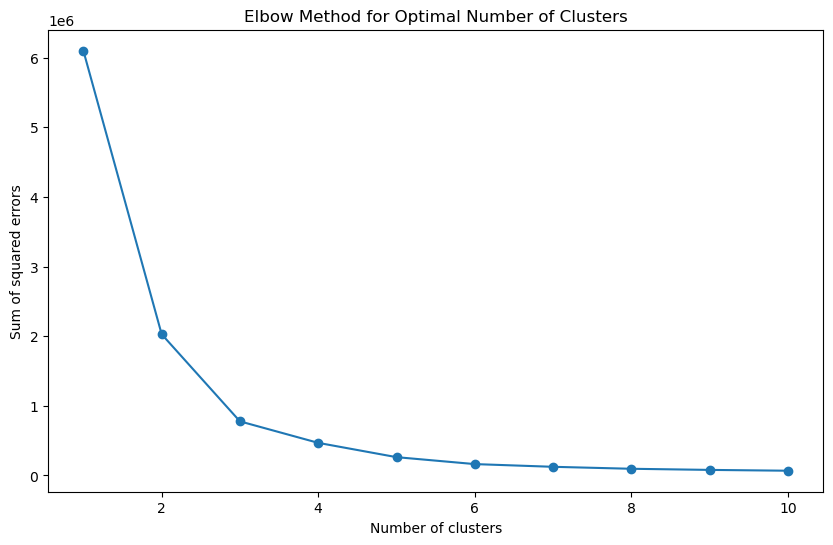

In [101]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(season_df[['level', 'average_rest_days', 'fatigue_units', 'average_muscle_fatigue', 'games_played', 'innings_pitched', 'total_pitches', 'WHIP', 'K/IP']])
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared errors')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [102]:
clusters = 4

kmeans = KMeans(n_clusters=clusters, random_state=42, n_init=10)
season_df['cluster'] = kmeans.fit_predict(season_df[['level', 'average_rest_days', 'fatigue_units', 'average_muscle_fatigue', 'games_played', 'innings_pitched', 'total_pitches', 'WHIP', 'K/IP']])

sil_score = silhouette_score(season_df[['level', 'average_rest_days', 'fatigue_units', 'average_muscle_fatigue', 'games_played', 'innings_pitched', 'total_pitches', 'WHIP', 'K/IP']], season_df['cluster'])
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.5784038903505766


In [103]:
cluster_summary = season_df.groupby('cluster').mean().reset_index()
cluster_summary.drop(columns=['pitcher'], inplace=True)

In [104]:
cluster_list = []
pitchers_list = season_df_extra['pitcher'].tolist()
level_list = season_df_extra['level'].tolist()
for i in range(len(season_df_extra)):
    pitcher_id = pitchers_list[i]
    level = level_list[i]
    cluster = season_df[(season_df['pitcher'] == pitcher_id) & (season_df['level'] == level)]['cluster'].values[0]
    cluster_list.append(cluster)
season_df_extra['cluster'] = cluster_list

In [105]:
cluster_summary_extra_df = season_df_extra.drop(columns=['pitcher']).groupby('cluster').mean().reset_index()

## Predictive Modelling
We choose XGBoost and random forest as classifier models since we can directly see the feature importances, which is helpful in identifying what particular metric is more significant in identifying pitcher roles.  

In [106]:
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [107]:
features = ['average_rest_days', 'fatigue_units', 'average_muscle_fatigue', 'games_played', 'total_pitches']
X = season_df[features]
y = season_df[['cluster']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [108]:
# XGB Classifier
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7916666666666666


In [109]:
# Random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, np.ravel(y_train))

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8958333333333334


## UI Development
### Note: The Dash app can currently run on localhost only. So user need to run *app.py* to use the app.
As the Random Forest Classifier has a higher accuracy, we will use the Random Forest model for the UI development. The dataframe containing the season metrics for the pitchers will also be saved for UI development.

In [110]:
import pickle
pickle_out = open("UImodel.pkl", "wb")
pickle.dump(rf, pickle_out)
pickle_out.close()

season_df.to_csv('UIdata.csv', index=False)

## Visualization

In [111]:
cluster_summary['cluster'] = cluster_summary['cluster'].map({0: 1, 1: 2, 2: 3, 3: 4})
season_df['cluster'] = season_df['cluster'].map({0: 1, 1: 2, 2: 3, 3: 4})
cluster_summary_extra_df['cluster'] = cluster_summary_extra_df['cluster'].map({0: 1, 1: 2, 2: 3, 3: 4})

In [112]:
pastel_colors = sns.color_palette("pastel")

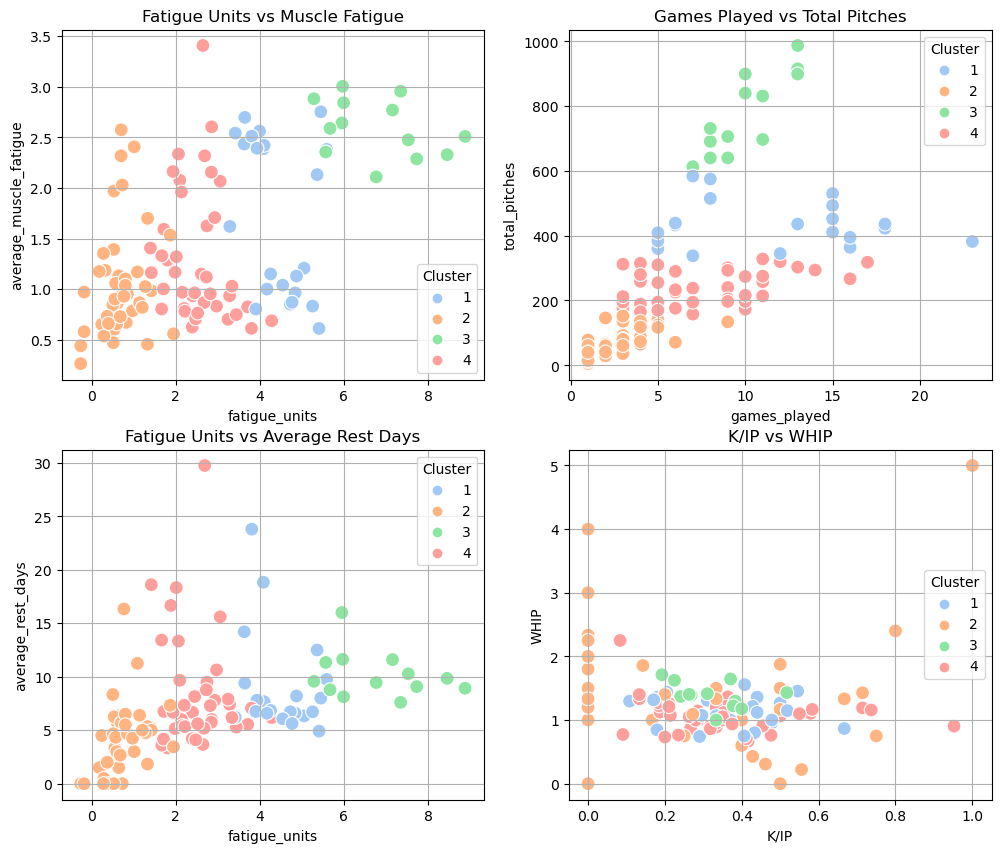

In [113]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.scatterplot(data=season_df, x='fatigue_units', y='average_muscle_fatigue', hue='cluster', palette='pastel', s=100)
plt.title('Fatigue Units vs Muscle Fatigue')
plt.xlabel('fatigue_units')
plt.ylabel('average_muscle_fatigue')
plt.legend(title='Cluster')
plt.grid(True)

plt.subplot(2, 2, 2)
sns.scatterplot(data=season_df, x='games_played', y='total_pitches', hue='cluster', palette='pastel', s=100)
plt.title('Games Played vs Total Pitches')
plt.xlabel('games_played')
plt.ylabel('total_pitches')
plt.legend(title='Cluster')
plt.grid(True)

plt.subplot(2, 2, 3)
sns.scatterplot(data=season_df, x='fatigue_units', y='average_rest_days', hue='cluster', palette='pastel', s=100)
plt.title('Fatigue Units vs Average Rest Days')
plt.xlabel('fatigue_units')
plt.ylabel('average_rest_days')
plt.legend(title='Cluster')
plt.grid(True)

plt.subplot(2, 2, 4)
sns.scatterplot(data=season_df, x='K/IP', y='WHIP', hue='cluster', palette='pastel', s=100)
plt.title('K/IP vs WHIP')
plt.xlabel('K/IP')
plt.ylabel('WHIP')
plt.legend(title='Cluster')
plt.grid(True)



plt.show()

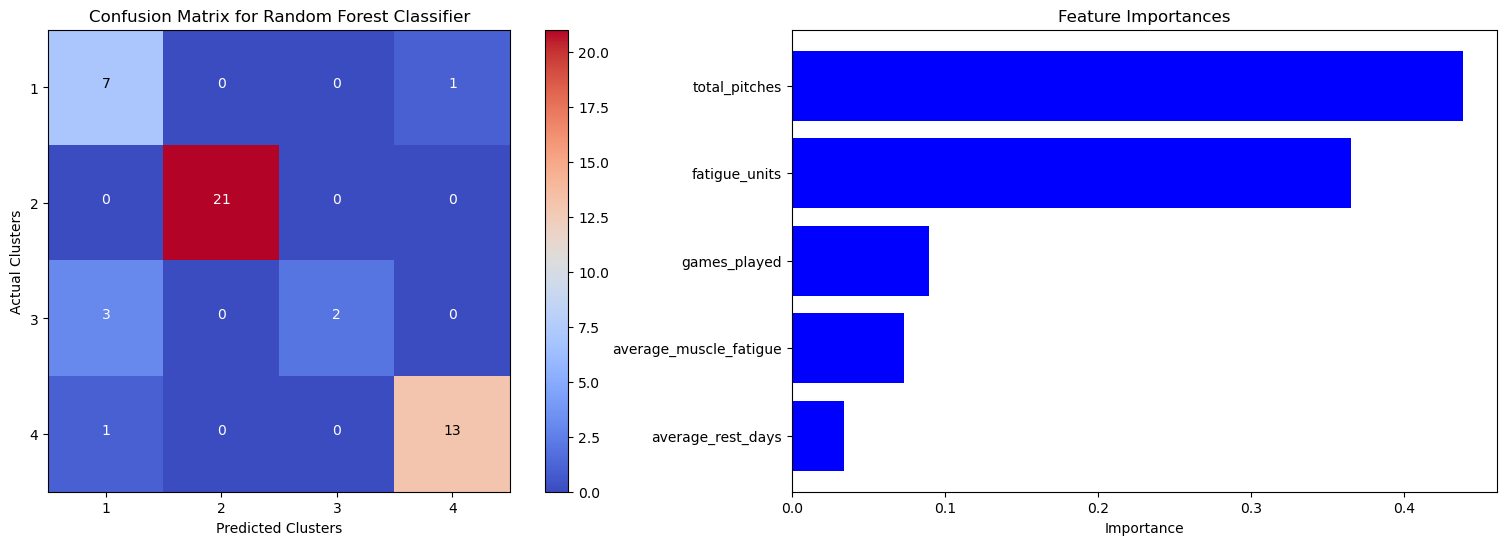

In [114]:
categories = ['1', '2', '3', '4']  
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.imshow(cm, interpolation='nearest', cmap='coolwarm')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.colorbar()

tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories)
plt.yticks(tick_marks, categories)

thresh = cm.max() / 3
for i in range(len(categories)):
    for j in range(len(categories)):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if (cm[i, j] > (cm.max() - thresh) or cm[i, j] < thresh) else "black")
plt.xlabel('Predicted Clusters')
plt.ylabel('Actual Clusters')

importances = rf.feature_importances_
indices = np.argsort(importances)

plt.subplot(1,2,2)
plt.title("Feature Importances")
plt.barh(range(X.shape[1]), importances[indices], color="blue", align="center")
plt.yticks(range(X.shape[1]), np.array(features)[indices])
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.gca().invert_yaxis()

plt.show()

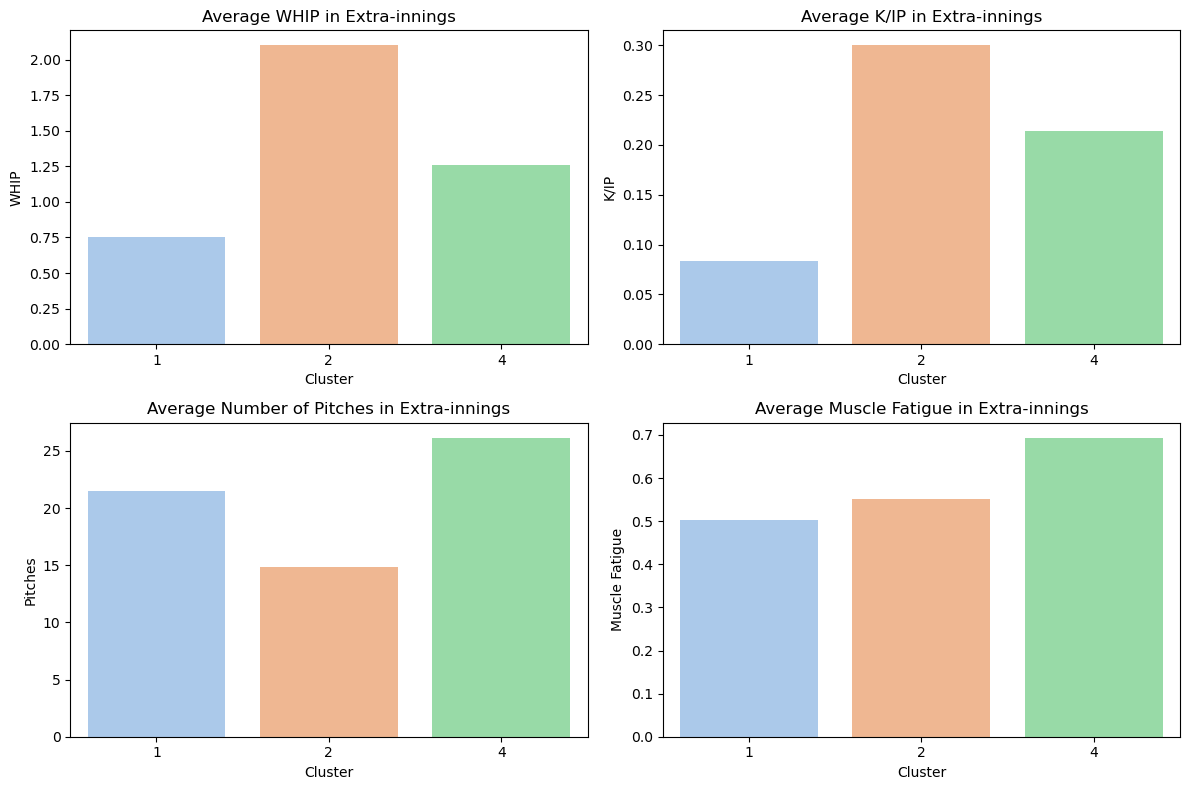

In [115]:
# Plotting the average performance metrics for each cluster
plt.figure(figsize=(12, 8))

# WHIP by cluster
plt.subplot(2, 2, 1)
sns.barplot(x=cluster_summary_extra_df['cluster'], y=cluster_summary_extra_df['WHIP'], palette='pastel')
plt.title('Average WHIP in Extra-innings')
plt.xlabel('Cluster')
plt.ylabel('WHIP')

# Strikeouts per inning by cluster
plt.subplot(2, 2, 2)
sns.barplot(x=cluster_summary_extra_df['cluster'], y=cluster_summary_extra_df['K/IP'], palette='pastel')
plt.title('Average K/IP in Extra-innings')
plt.xlabel('Cluster')
plt.ylabel('K/IP')

# Total pitches by cluster
plt.subplot(2, 2, 3)
sns.barplot(x=cluster_summary_extra_df['cluster'], y=cluster_summary_extra_df['total_pitches'], palette='pastel')
plt.title('Average Number of Pitches in Extra-innings')
plt.xlabel('Cluster')
plt.ylabel('Pitches')

# Muscle fatigue by cluster
plt.subplot(2, 2, 4)
sns.barplot(x=cluster_summary_extra_df['cluster'], y=cluster_summary_extra_df['average_muscle_fatigue'], palette='pastel')
plt.title('Average Muscle Fatigue in Extra-innings')
plt.xlabel('Cluster')
plt.ylabel('Muscle Fatigue')

plt.tight_layout()
plt.show()

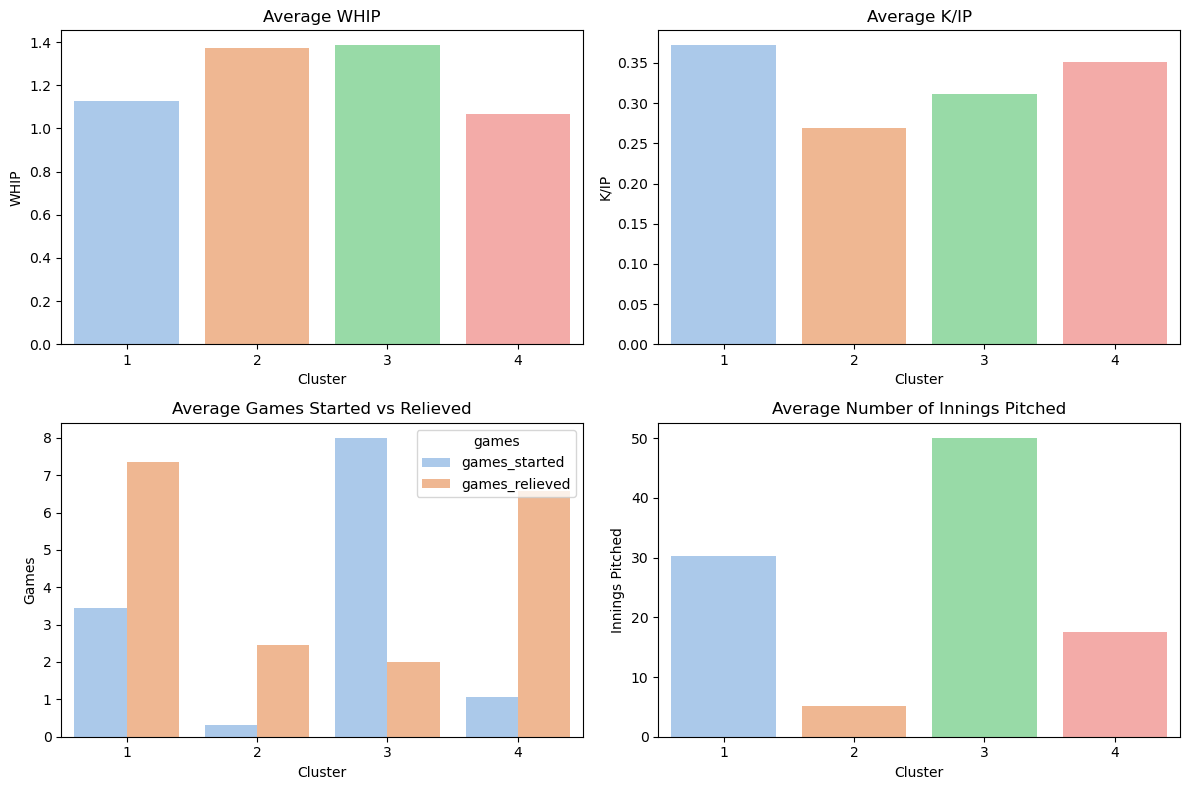

In [116]:
# Plotting the average performance metrics for each cluster
plt.figure(figsize=(12, 8))

# WHIP by cluster
plt.subplot(2, 2, 1)
sns.barplot(x=cluster_summary['cluster'], y=cluster_summary['WHIP'], palette='pastel')
plt.title('Average WHIP')
plt.xlabel('Cluster')
plt.ylabel('WHIP')

# Strikeouts per inning by cluster
plt.subplot(2, 2, 2)
sns.barplot(x=cluster_summary['cluster'], y=cluster_summary['K/IP'], palette='pastel')
plt.title('Average K/IP')
plt.xlabel('Cluster')
plt.ylabel('K/IP')

# Games started vs relieved by cluster
melted_df = cluster_summary.melt(id_vars=['cluster'], 
                    value_vars=['games_started', 'games_relieved'],
                    var_name='games', value_name='value')
plt.subplot(2, 2, 3)
sns.barplot(x='cluster', y='value', hue='games', data=melted_df, palette='pastel')
plt.title('Average Games Started vs Relieved')
plt.xlabel('Cluster')
plt.ylabel('Games')

# Innings pitched by cluster
plt.subplot(2, 2, 4)
sns.barplot(x=cluster_summary['cluster'], y=cluster_summary['innings_pitched'], palette='pastel')
plt.title('Average Number of Innings Pitched')
plt.xlabel('Cluster')
plt.ylabel('Innings Pitched')

plt.tight_layout()
plt.show()

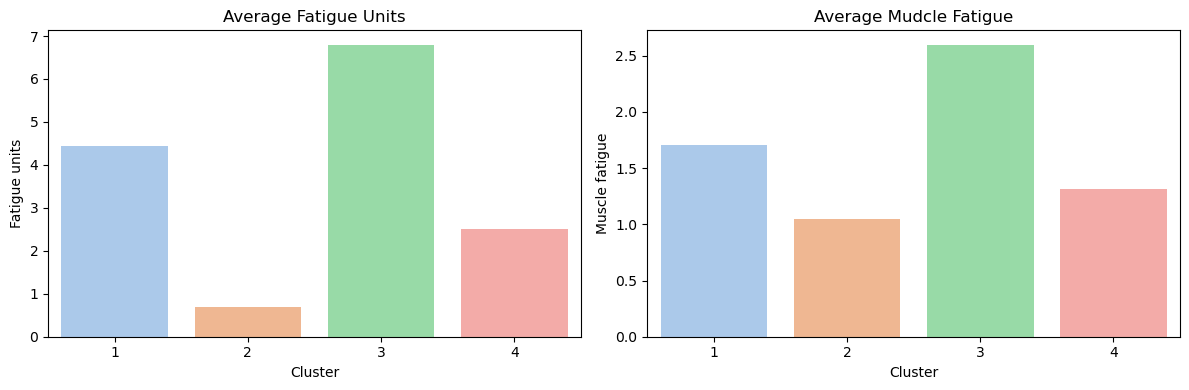

In [117]:
# Plotting the average performance metrics for each cluster
plt.figure(figsize=(12, 4))

# Fatigue units by cluster
plt.subplot(1, 2, 1)
sns.barplot(x=cluster_summary['cluster'], y=cluster_summary['fatigue_units'], palette='pastel')
plt.title('Average Fatigue Units')
plt.xlabel('Cluster')
plt.ylabel('Fatigue units')

# Muscle fatigue by cluster
plt.subplot(1, 2, 2)
sns.barplot(x=cluster_summary['cluster'], y=cluster_summary['average_muscle_fatigue'], palette='pastel')
plt.title('Average Mudcle Fatigue')
plt.xlabel('Cluster')
plt.ylabel('Muscle fatigue')

plt.tight_layout()
plt.show()

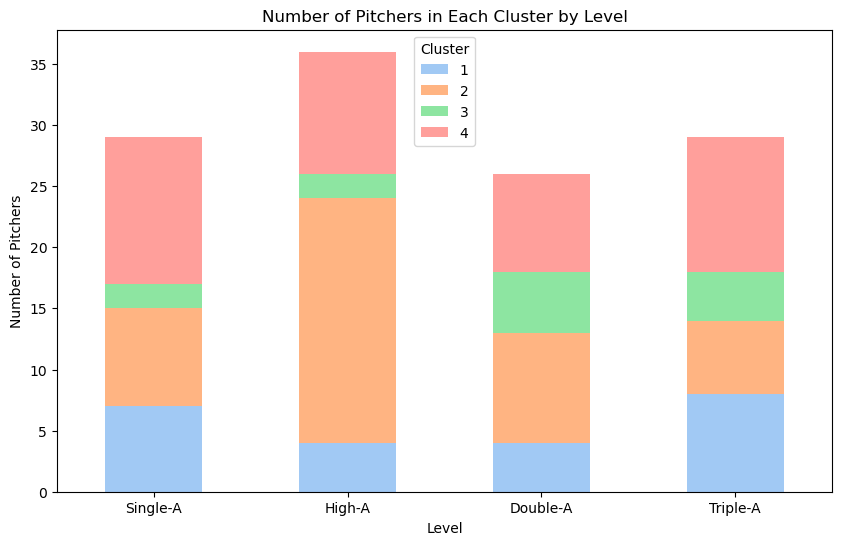

In [118]:
cluster_counts = season_df.groupby(['level', 'cluster']).size().reset_index(name='counts')
cluster_pivot = cluster_counts.pivot(index='level', columns='cluster', values='counts')
cluster_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), color=pastel_colors)
plt.title('Number of Pitchers in Each Cluster by Level')
plt.xticks(ticks=[0,1,2,3],labels=['Single-A', 'High-A', 'Double-A', 'Triple-A'], rotation=0)
plt.xlabel('Level')
plt.ylabel('Number of Pitchers')
plt.legend(title='Cluster', loc='upper center')
plt.show()

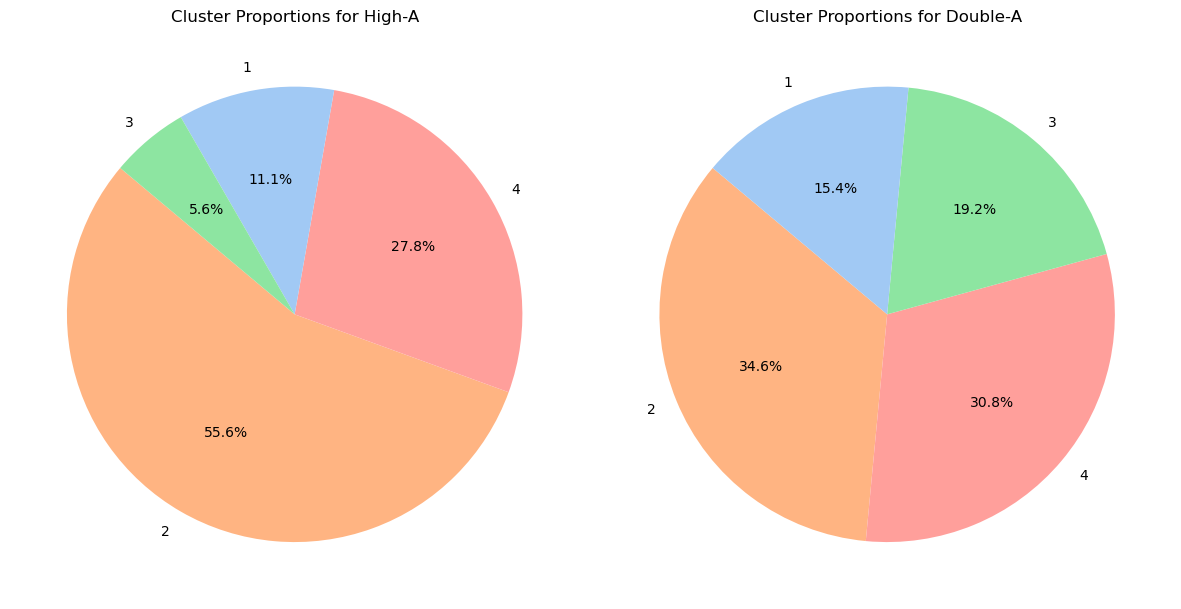

In [119]:
color_mapping = {
    1: pastel_colors[0],  # Blue
    2: pastel_colors[1],  # Orange
    3: pastel_colors[2],  # Green
    4: pastel_colors[3]   # Red
}

# Function to get colors based on cluster mapping
def get_colors_for_clusters(cluster_series, color_mapping):
    return [color_mapping[cluster] for cluster in cluster_series.unique()]


cluster_counts_highA = season_df[season_df['level'] == 2]['cluster'].value_counts()
cluster_counts_doubleA = season_df[season_df['level'] == 3]['cluster'].value_counts()


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
colors_level2 = get_colors_for_clusters(cluster_counts_highA.index, color_mapping)
plt.pie(cluster_counts_highA, 
        labels=cluster_counts_highA.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=colors_level2)
plt.title('Cluster Proportions for High-A')


plt.subplot(1, 2, 2)
colors_level3 = get_colors_for_clusters(cluster_counts_doubleA.index, color_mapping)
plt.pie(cluster_counts_doubleA, 
        labels=cluster_counts_doubleA.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=colors_level3)
plt.title('Cluster Proportions for Double-A')

plt.tight_layout()
plt.show()

## Results
The result is shown in a .csv file containing the role that each pitcher belongs to.

In [120]:
season_df['roles'] = season_df['cluster'].apply(lambda x: 'Versatile Reliever' if x == 1 else 'Middle Reliever' if x == 2 else 'Starting Pitcher' if x == 3 else 'Closer')

In [121]:
season_df[['level', 'pitcher', 'roles']].to_csv('results.csv', index=False)